In [1]:
#Import Libraries
import numpy as np
import gurobipy as gp
import pandas as pd

In [2]:
#Uploading Training and Test Datasets
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
#Setting Time limit for each run
time_limit = 12*3600//100

#Setting some variable counts
no_of_valid_set = 10
size_of_train_data = len(train)
size_of_valid_data = int(len(train)/no_of_valid_set)

## Function for MIQP

In [4]:
# Function takes input the number of variables to select and performs the cross validation and calculates the
# Sum of the Squared Errors(SSE) and Mean Squared Errors(MSE) 

def get_optimal_betas(variables_to_select):
    
    index = np.random.choice(size_of_train_data, size_of_train_data, replace = False )
    
    # Initialize Dataframe for variable count and MSE
    df_MSE = pd.DataFrame(columns=['variable_count','MSE', 'SSE'])
    
    # For Loop for 10 rounds of Min MSE with different validation set for one variable count
    for count in range(no_of_valid_set):
        i = count*size_of_valid_data
        start = i
        end = i+size_of_valid_data
        valid_index = index[start:end]
        
        # Creating the Validation Dataset
        X_valid = train.iloc[valid_index]
        
        # Creating the Training Dataset
        train_index = np.concatenate((index[:start], index[end:]))
        X_train = train.iloc[train_index]
        
        # Defining the number of vaiables
        no_of_variables = len(X_train.columns) - 1
        
        # Setting the value of Big M
        M = 1000
        
        # Creating the X matrix
        train1 = np.array(X_train.drop('y', axis=1))
        train2 = np.insert(train1,0,1,axis=1)
        
        # Creating the Q matrix
        Q = np.zeros(((2*no_of_variables + 1),(2*no_of_variables + 1)))
        Q1 = train2.T @ train2

        Q[0:Q1.shape[0], 0:Q1.shape[1]] = Q1
        
        # Creating the L matrix
        L_new = np.zeros(2*no_of_variables + 1)
        L = L_new.T

        L1 = -2*(X_train['y'].T @ train2)
        L[0:L1.shape[0]] = L1

        # Adding the constraints

        no_of_constraints = (2*no_of_variables)+1

        A = np.zeros((no_of_constraints, no_of_constraints)) # initialize A matrix
        b = np.zeros((no_of_constraints)) # initialize b matrix
        sense = [0]*no_of_constraints # initialize sense matrix

        # Constraint 1 -> sum of zi == no. of variables to be selected
        A[0, 1+no_of_variables: ] = [1]*no_of_variables
        b[0] = variables_to_select
        sense[0] = '<'

        # Constraint 2 -> Big M constraint for upper limit
        p = 1
        for i in range(1,no_of_variables+1):
            A[p,[i,i+no_of_variables]] = [1, -M]
            b[p] = 0
            sense[p] = '<'
            p = p+1

        # Constraint 3 -> Big M constraint for lower limit
        for i in range(1,no_of_variables+1):
            A[p,[i,i+no_of_variables]] = [1, M]
            b[p] = 0
            sense[p] = '>'
            p = p+1

        sense = np.array(sense)

        # Optimization code

        VarMod = gp.Model()
        VarMod_x = VarMod.addMVar(2*no_of_variables+1, vtype=['C']*(1 + no_of_variables)+['B']*no_of_variables, \
                                  lb=np.array([-1000]*(no_of_variables+1) + [0]*no_of_variables))
        VarMod_con = VarMod.addMConstr(A, VarMod_x, sense, b)
        VarMod.setMObjective(Q,L,0,sense=gp.GRB.MINIMIZE)

        VarMod.Params.OutputFlag = 0 
        VarMod.params.TimeLimit = time_limit
        
        VarMod.optimize()
        
        # Storing the beta coefficients
        beta = VarMod_x.x[0:no_of_variables+1]

        #Preparing Validation data for finding predicted y
        valid1 = np.array(X_valid.drop('y', axis=1))
        valid2 = np.insert(valid1,0,1,axis=1)

        y_valid = pd.DataFrame(X_valid['y'])
        y_valid['y_pred'] = (valid2 @ beta)
        y_valid['sq_diff'] = (y_valid['y_pred'] - y_valid['y'])**2
        
        MSE = y_valid['sq_diff'].mean()
        SSE = y_valid['sq_diff'].sum()
        df_MSE.loc[len(df_MSE)] = [variables_to_select, MSE, SSE]

    return df_MSE

## MIQP Results

In [9]:
# Storing the MIQP results in a csv
df_MSE_per_n = pd.DataFrame(columns=['variable_count','MSE','SSE'])
frames = []

for n in range(5,51,5):
    frames.append(get_optimal_betas(n))
    
MIQP_result = pd.concat(frames) 
MIQP_result.to_csv('MIQP_result.csv')

In [123]:
MIQP_result

,variable_count,MSE,SSE
0,5.0,5.264235,131.605866
1,5.0,2.164562,54.114046
2,5.0,3.934494,98.362346
3,5.0,5.430667,135.766672
4,5.0,3.953641,98.841025
...,...,...,...
5,50.0,4.439295,110.982374
6,50.0,2.562189,64.054721
7,50.0,3.112782,77.819541
8,50.0,2.357950,58.948740


<AxesSubplot:xlabel='variable_count'>

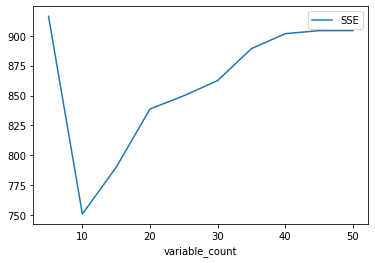

In [20]:
# Draw conclusions and graphs
MIQP_result.pivot_table(index='variable_count', aggfunc={'SSE':sum}, fill_value=0).plot(kind='line')

In [25]:
MIQP_SSE = MIQP_result.pivot_table(index='variable_count', aggfunc={'SSE':sum}, fill_value=0)
best_variable_count = MIQP_SSE['SSE'].idxmin()
best_variable_count

10.0

In [65]:
# Using the MIQP results, found the best variable count to fit the training data

# Finding betas on training dataset
variables_to_select = best_variable_count
no_of_variables = len(train.columns) - 1
M = 1000

# Initialize Dataframe for variable count and MSE
df_MSE_n = pd.DataFrame(columns=['variable_count','MSE', 'SSE'])

train1 = np.array(train.drop('y', axis=1))
train2 = np.insert(train1,0,1,axis=1)

Q = np.zeros(((2*no_of_variables + 1),(2*no_of_variables + 1)))
Q1 = train2.T @ train2

Q[0:Q1.shape[0], 0:Q1.shape[1]] = Q1

L_new = np.zeros(2*no_of_variables + 1)
L = L_new.T

L1 = -2*(train['y'].T @ train2)
L[0:L1.shape[0]] = L1

# Adding the constraints

no_of_constraints = (2*no_of_variables)+1

A = np.zeros((no_of_constraints, no_of_constraints)) # initialize A matrix
b = np.zeros((no_of_constraints)) # initialize b matrix
sense = [0]*no_of_constraints # initialize sense matrix

# Constraint 1 -> sum of zi == no. of variables to be selected
A[0, 1+no_of_variables: ] = [1]*no_of_variables
b[0] = variables_to_select
sense[0] = '<'

# Constraint 2 -> Big M constraint for upper limit
p = 1
for i in range(1,no_of_variables+1):
    A[p,[i,i+no_of_variables]] = [1, -M]
    b[p] = 0
    sense[p] = '<'
    p = p+1

# Constraint 3 -> Big M constraint for lower limit
for i in range(1,no_of_variables+1):
    A[p,[i,i+no_of_variables]] = [1, M]
    b[p] = 0
    sense[p] = '>'
    p = p+1

sense = np.array(sense)

# Optimization code

VarMod = gp.Model()
VarMod_x = VarMod.addMVar(2*no_of_variables+1, vtype=['C']*(1 + no_of_variables)+['B']*no_of_variables, \
                          lb=np.array([-1000]*(no_of_variables+1) + [0]*no_of_variables))
VarMod_con = VarMod.addMConstr(A, VarMod_x, sense, b)
VarMod.setMObjective(Q,L,0,sense=gp.GRB.MINIMIZE)

VarMod.Params.OutputFlag = 0 
VarMod.params.TimeLimit = time_limit

VarMod.optimize()

beta = VarMod_x.x[0:no_of_variables+1]
coeff_MIQP = pd.DataFrame(beta)

#Preparing test data for finding predicted y
test1 = np.array(test.drop('y', axis=1))
test2 = np.insert(test1,0,1,axis=1)

y_test = pd.DataFrame(test['y'])
y_test['y_pred'] = (test2 @ beta)
y_test['sq_diff'] = (y_test['y_pred'] - y_test['y'])**2

MSE = y_test['sq_diff'].mean()
SSE = y_test['sq_diff'].sum()

df_MSE_n.loc[len(df_MSE_n)] = [variables_to_select, MSE, SSE]

print(df_MSE_n)

   variable_count       MSE         SSE
0            10.0  2.336544  116.827198


In [111]:
beta_coeff_MIQP = coeff_MIQP[1:].reset_index()
beta_coeff_MIQP.drop(columns=['index'], inplace=True)
beta_coeff_MIQP.rename(columns = {0:'MIQP_beta'}, inplace = True)
beta_coeff_MIQP[beta_coeff_MIQP['MIQP_beta'] != 0]
# .sort_values(by=['MIQP_beta'])

,MIQP_beta
8,-2.308207
14,-0.518326
15,-0.204162
22,-1.559143
23,0.866973
25,-1.311919
33,0.408165
44,1.781475
46,0.887383
47,-0.282292


## Lasso Using Scikit Learn

In [119]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries for Scaling the dataset
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

# Libraries for K-Fold cross validation
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate

# Creating 2 dataframes for x and y
# Train
X_train=train.drop('y',axis=1)
Y_train = train['y']

# Test
X_test=test.drop('y',axis=1)
Y_test = test['y']

# Scaling the x data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Cross validation and neg MSE 

# Setting the range for alpha values to (100,0.0001)
alpha = 10**np.linspace(2,-4,100)

lasso_neg_mse_vals = []

for a in alpha:

    lasso_cv_n_mse = cross_validate(Lasso(alpha = a), X_train, Y_train, scoring='neg_mean_squared_error', cv=10, 
        return_train_score = True)
        
    lasso_neg_mse_vals.append(lasso_cv_n_mse['test_score'].mean())
    
list_of_tuples_lasso = list(zip(alpha, lasso_neg_mse_vals ))   

# Converting lists of tuples into pandas Dataframe
lasso_nmse_df = pd.DataFrame(list_of_tuples_lasso,
                  columns=['alpha', 'lasso_neg_mse_vals'])

In [120]:
lasso_nmse_df.set_index(['alpha'], inplace = True)
best_alpha_lasso = lasso_nmse_df[['lasso_neg_mse_vals']].idxmax()
print(best_alpha_lasso)

lasso_neg_mse_vals    0.081113
dtype: float64


Text(0, 0.5, 'MSE')

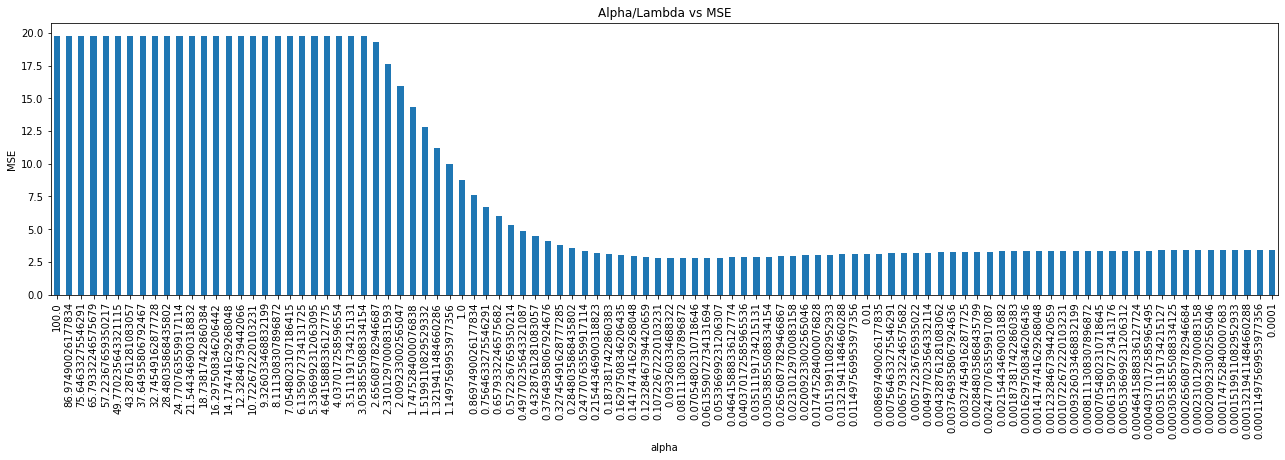

In [121]:
lasso_nmse_df['Lasso_MSE']=(lasso_nmse_df['lasso_neg_mse_vals']*(-1))
lasso_nmse_df['Lasso_MSE'].plot(kind='bar')
plt.rcParams['figure.figsize'] = [22, 5]
plt.title("Alpha/Lambda vs MSE")
plt.ylabel("MSE")

In [92]:
# Linear Regression with Lasso regularization results

lasso_reg = Lasso(alpha=best_alpha_lasso[0])

lasso_reg.fit(X_train, Y_train)

Y_pred_train = lasso_reg.predict(X_train)
Y_pred_test = lasso_reg.predict(X_test)

from sklearn.metrics import mean_squared_error
lasso_MSE_train = mean_squared_error(Y_train, Y_pred_train)
lasso_MSE_test = mean_squared_error(Y_test, Y_pred_test)

print("Test MSE of lasso regression is: ", lasso_MSE_test)

coeff = []

coeff_alpha = list(lasso_reg.coef_)
coeff.append(coeff_alpha)

lasso_coeff = pd.DataFrame(coeff).T
lasso_coeff.rename(columns = {0:'Lasso_beta'}, inplace = True)

Test MSE of lasso regression is:  2.3610589089053495


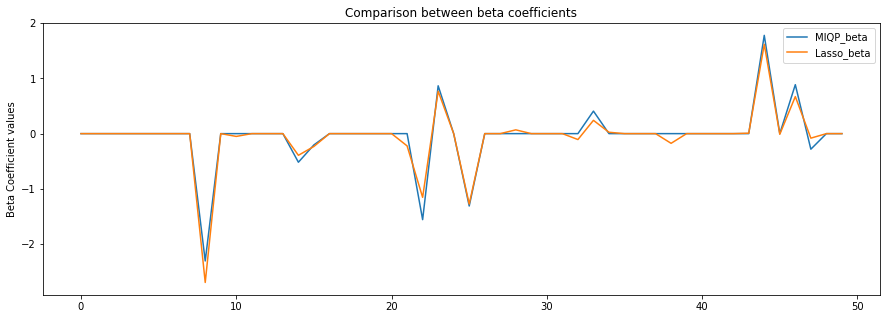

In [168]:
frames_beta = [beta_coeff_MIQP, lasso_coeff]

merged_betas = pd.concat(frames_beta, axis=1)
merged_betas.plot(kind='line')
plt.title("Comparison between beta coefficients")
plt.ylabel("Beta Coefficient values")
plt.rcParams['figure.figsize'] = [15, 5]